<a href="https://colab.research.google.com/github/Aravind7474/seminar_codes/blob/main/MS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Encoder definition
class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, latent_dim=64):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, latent_dim, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.conv(x)

# Decoder definition
class Decoder(nn.Module):
    def __init__(self, latent_dim=64, hidden_channels=64, out_channels=1):
        super(Decoder, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Scale output between 0 and 1
        )

    def forward(self, x):
        return self.deconv(x)

# Vector Quantizer for VQ-VAE
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        # Flatten input: (B, latent_dim, H, W) -> (B*H*W, latent_dim)
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)

        # Compute distances between flat_input and embeddings
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))

        # Find nearest embeddings
        encoding_indices = torch.argmin(distances, dim=1)
        encodings = torch.nn.functional.one_hot(encoding_indices, self.num_embeddings).float()

        # Quantize and reshape back to input shape
        quantized = torch.matmul(encodings, self.embeddings.weight).view(input_shape)

        # Compute commitment losses
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()

        return quantized, loss

# VQ-VAE model that combines encoder, vector quantizer, and decoder
class VQVAE(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, latent_dim=64, num_embeddings=128, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels, latent_dim)
        self.vector_quantizer = VectorQuantizer(num_embeddings, latent_dim, commitment_cost)
        self.decoder = Decoder(latent_dim, hidden_channels, in_channels)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss = self.vector_quantizer(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss



In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Encoder definition
class Encoder(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, latent_dim=64):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, latent_dim, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.conv(x)

# Decoder definition
class Decoder(nn.Module):
    def __init__(self, latent_dim=64, hidden_channels=64, out_channels=1):
        super(Decoder, self).__init__()
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, hidden_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, hidden_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(hidden_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Scale output between 0 and 1
        )

    def forward(self, x):
        return self.deconv(x)

# Vector Quantizer for VQ-VAE
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, inputs):
        # Flatten input: (B, latent_dim, H, W) -> (B*H*W, latent_dim)
        input_shape = inputs.shape
        flat_input = inputs.view(-1, self.embedding_dim)

        # Compute distances between flat_input and embeddings
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))

        # Find nearest embeddings
        encoding_indices = torch.argmin(distances, dim=1)
        encodings = torch.nn.functional.one_hot(encoding_indices, self.num_embeddings).float()

        # Quantize and reshape back to input shape
        quantized = torch.matmul(encodings, self.embeddings.weight).view(input_shape)

        # Compute commitment losses
        e_latent_loss = torch.mean((quantized.detach() - inputs)**2)
        q_latent_loss = torch.mean((quantized - inputs.detach())**2)
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()

        return quantized, loss

# VQ-VAE model that combines encoder, vector quantizer, and decoder
class VQVAE(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=64, latent_dim=64, num_embeddings=128, commitment_cost=0.25):
        super(VQVAE, self).__init__()
        self.encoder = Encoder(in_channels, hidden_channels, latent_dim)
        self.vector_quantizer = VectorQuantizer(num_embeddings, latent_dim, commitment_cost)
        self.decoder = Decoder(latent_dim, hidden_channels, in_channels)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss = self.vector_quantizer(z_e)
        x_recon = self.decoder(z_q)
        return x_recon, vq_loss


In [4]:
def create_sample_dataset(num_samples=1000, channels=1, height=32, width=32):
    """
    Simulate a dataset of 2D histograms.
    In a real scenario, replace this with your preprocessing converting
    spatio-temporal data into the required format.
    """
    data = torch.rand(num_samples, channels, height, width)
    return data

# Create and wrap the dataset in a DataLoader
data = create_sample_dataset(num_samples=1000, channels=1, height=32, width=32)
dataset = TensorDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [5]:
def train_vqvae(model, dataloader, num_epochs=10, learning_rate=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    recon_loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        total_recon_loss = 0
        total_vq_loss = 0
        for batch in dataloader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            x_recon, vq_loss = model(batch)
            recon_loss = recon_loss_fn(x_recon, batch)
            loss = recon_loss + vq_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_vq_loss += vq_loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}, Recon Loss: {total_recon_loss/len(dataloader):.4f}, VQ Loss: {total_vq_loss/len(dataloader):.4f}")

    return model

# Initialize and train the VQ-VAE model
model = VQVAE(in_channels=1, hidden_channels=64, latent_dim=64, num_embeddings=128, commitment_cost=0.25)
trained_model = train_vqvae(model, dataloader, num_epochs=10, learning_rate=1e-3)


Epoch 1/10, Loss: 0.0839, Recon Loss: 0.0834, VQ Loss: 0.0005
Epoch 2/10, Loss: 0.0836, Recon Loss: 0.0833, VQ Loss: 0.0003
Epoch 3/10, Loss: 0.0868, Recon Loss: 0.0831, VQ Loss: 0.0037
Epoch 4/10, Loss: 0.0980, Recon Loss: 0.0825, VQ Loss: 0.0155
Epoch 5/10, Loss: 0.1099, Recon Loss: 0.0815, VQ Loss: 0.0284
Epoch 6/10, Loss: 0.1284, Recon Loss: 0.0806, VQ Loss: 0.0478
Epoch 7/10, Loss: 0.1601, Recon Loss: 0.0795, VQ Loss: 0.0806
Epoch 8/10, Loss: 0.1882, Recon Loss: 0.0786, VQ Loss: 0.1096
Epoch 9/10, Loss: 0.2111, Recon Loss: 0.0775, VQ Loss: 0.1336
Epoch 10/10, Loss: 0.2415, Recon Loss: 0.0765, VQ Loss: 0.1650


In [6]:
# Save the trained model (optional)
torch.save(trained_model.state_dict(), "vqvae_model.pth")

# Perform inference on a sample batch
trained_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sample_batch = next(iter(dataloader))[0].to(device)
with torch.no_grad():
    reconstruction, _ = trained_model(sample_batch)
print("Inference completed. Sample reconstruction shape:", reconstruction.shape)


Inference completed. Sample reconstruction shape: torch.Size([32, 1, 32, 32])


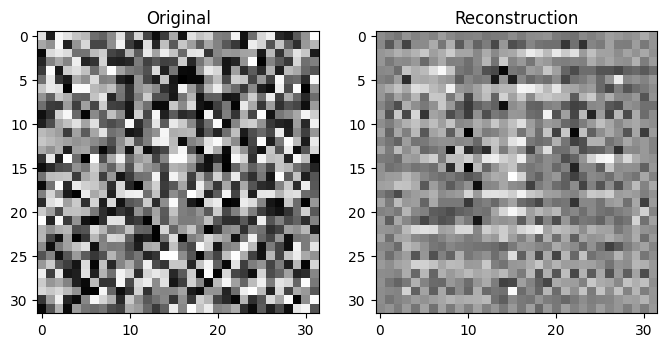

In [7]:
import matplotlib.pyplot as plt

# Visualize original and reconstructed images from the sample batch
sample_img = sample_batch[0].cpu().numpy().squeeze()
recon_img = reconstruction[0].cpu().numpy().squeeze()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(sample_img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Reconstruction")
plt.imshow(recon_img, cmap='gray')
plt.show()
